# 필요한 라이브러리 import

In [62]:
import os
import json
import numpy as np
import pandas as pd
from gensim import corpora
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as spr
import configparser
import pymysql
from itertools import chain
from collections import defaultdict,Counter
import hnswlib
import warnings
import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from implicit.als import AlternatingLeastSquares
from sklearn.decomposition import NMF
from itertools import repeat
from sklearn.preprocessing import MinMaxScaler
import random
from scipy.stats import skew
warnings.filterwarnings(action='ignore')

# 데이터 로드

In [2]:
with open('./data/song_meta.json',encoding='utf-8-sig') as f:
    song_dict = json.load(f)
    
song_df = pd.DataFrame.from_dict(song_dict)

In [3]:
with open('./data/genre_gn_all.json',encoding='utf-8-sig') as f:
    genre_dict = json.load(f)

In [4]:
with open('data/train.json',encoding='utf-8-sig') as f:
    train_dict = json.load(f)
    
train_df = pd.DataFrame.from_dict(train_dict)

# 태그-id간 동기화를 위한 데이터베이스 연결

In [5]:
# config parser 객체 생성
config = configparser.ConfigParser()

# parser객체로 config.ini 파일 읽기
config.read('config.ini')

# 연결 config 변수저장

user = config['DEFAULT']['ADMIN_USER_NAME']
passwd = config['DEFAULT']['ADMIN_PASSWORD']
host = config['DEFAULT']['RDS_ENDPOINT']
port = config['DEFAULT']['PORT']
database = config['DEFAULT']['DEFAULT_DATABASE']

In [6]:
# 데이터 베이스 연결
melon_recom_db = pymysql.connect(
    host = host,
    user = user,
    password = passwd,
    database = database,
    port = int(port),
    cursorclass = pymysql.cursors.DictCursor
)

In [7]:
# 커서 생성 후 쿼리문 수행
melon_cursor = melon_recom_db.cursor()
melon_cursor.execute('select tag_id,tag from tag')
tag_db_list=melon_cursor.fetchall()

# tag 딕셔너리 만들기 

In [8]:
# tag를 id로
tag_to_id = {}

# id를 tag로
id_to_tag = {}

for tag_db in tag_db_list:
    tag_to_id[tag_db['tag']] = tag_db['tag_id']
    
for tag_db in tag_db_list:
    id_to_tag[tag_db['tag_id']] = tag_db['tag']

# tag 전처리 빈도수로 컷

In [9]:
# train dataframe tag 컬럼의 모든 tag들 (중복포함)
tags_all = train_df['tags'].tolist()

# 태그의 빈도수를 가진 dict, Counter 써도 됨
tags_frequency = defaultdict(int)

# 특정 tag가 나올 때마다 1더하기
for tags in tags_all:
    for tag in tags:
        tags_frequency[tag] += 1

In [10]:
# 태그 빈도의 분포를 알아보자
tag_freq = pd.DataFrame().from_dict(tags_frequency,orient="index")
tag_freq.columns=['빈도']
tag_freq.describe().T

,count,mean,std,min,25%,50%,75%,max
빈도,29160.0,16.335082,247.011075,1.0,1.0,1.0,3.0,16465.0


In [11]:
# 빈도수로 태그를 filter

def filter_func(x):
    temp = []
    for tag in x:
        if tags_frequency[tag] > 20:
            temp.append(tag)
        else:
            pass
    return temp
            
train_df['tags'] = train_df['tags'].map(filter_func)

In [12]:
# filter된 태그의 id만 남기기
train_df['tag_ids'] = train_df['tags'].map(lambda x : [tag_to_id[v] for v in x])
train_df.head(1)

,tags,id,plylst_title,songs,like_cnt,updt_date,tag_ids
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,[25304]


## 컬럼명 한글화

In [13]:
train_df.columns=['태그','플리아이디','플리제목','노래들','좋아요수','변경일자','태그아이디']

In [14]:
train_df['태그수'] = train_df['태그'].map(len)

In [15]:
train_df.head(1)

,태그,플리아이디,플리제목,노래들,좋아요수,변경일자,태그아이디,태그수
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,[25304],1


# Train Test Split

In [16]:
# 태그가 10개인거 부터 train에 쓸거임
origin_tags = train_df[train_df['태그수']>2]['태그'].tolist()

train_tags = []
test_tags = []

# 태그는 많아봐야 3개 사분위수 75% -> 3개
for tags in origin_tags:
    tag_3p = len(tags)//3
    train_tag = random.sample(tags, tag_3p)
    test_tag = list(set(tags)-set(train_tag))
    train_tags.append(train_tag)
    test_tags.append(test_tag)

In [17]:
cal_tag_hit_df = pd.DataFrame(columns=['태그원본','예측용태그','검증용태그','svd_예측결과','svd_히트'])
cal_tag_hit_df['태그원본'] = origin_tags

In [18]:
cal_tag_hit_df['예측용태그'] = train_tags
cal_tag_hit_df['검증용태그'] = test_tags
cal_tag_hit_df.head()

,태그원본,예측용태그,검증용태그,svd_예측결과,svd_히트
0,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 겨울노래, 크리스마스, 겨울왕국]","[분위기, 겨울왕국]","[크리스마스, 따듯한, 눈오는날, 연말, 캐럴, 겨울노래]",NaN,NaN
1,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...","[일렉, 힐링, 드라이브]","[트로피컬하우스, 트렌드, 운동, Pop, 2017, 팝, 기분전환]",NaN,NaN
2,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]","[취향저격, 슬픔]","[고백, 사랑, 짝사랑, 이별]",NaN,NaN
3,"[잔잔한, 추억, 회상]",[잔잔한],"[추억, 회상]",NaN,NaN
4,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]","[포크, 메탈]","[일렉트로니카, 인디, 락, 댄스]",NaN,NaN


# 희소행렬생성 태그,음악 행렬

In [19]:
song_df.colums=['세부장르','발매일','앨범명','앨범ID','가수ID','노래명','대장르','가수명','노래ID']

In [20]:
genre_dict['GN9000'] = '기타장르'

genre_big = {}

# 모든 장르 딕셔너리를 돌면서
for k,v in genre_dict.items():
    
    # 맨 뒤 두자리가 00이면 대장류로 분류
    if k[-2:] == '00':
        
        # 맨앞 네자리를 키로 하는 대장류 딕셔너리 값 추가
        genre_big[k[:4]] = v

genre_detail_dict = {}

# 모든 딕셔너리를 돌면서
for k,v in genre_dict.items():
    
    # 맨뒤 두자리가 00이 아니면 대장류가 아닌거임!
    if k[-2:] != '00':
        
        # 그럴떈 아까만든 대장르 딕셔너리의 대장류 이름을 추가해서 이름을 수정해서 다시 넣어줌
        new_value = genre_big[k[:4]]+'_'+v
        genre_detail_dict[k] = new_value

# 태그 임베딩

## 세부장르ID와 CODE간 딕셔너리 생성

In [21]:
genre_detail_id_to_code = {}

for i,v in enumerate(list(genre_detail_dict.keys())):
    genre_detail_id_to_code[i] = v

In [22]:
genre_detail_code_to_id = {}

for i,v in enumerate(list(genre_detail_dict.keys())):
    genre_detail_code_to_id[v] = i

## 노래ID와 세부장르ID간 딕셔너리 생성

In [23]:
# 노래의 ID를 KEY 세부장르의 ID리스트를 ITEM으로 하는 딕셔너리 생성 

song_genre_detail_dict = defaultdict(list)

for codes,id in zip(song_df['song_gn_dtl_gnr_basket'].tolist(),song_df['id'].tolist()):
    for code in codes:
        song_genre_detail_dict[id].append(genre_detail_code_to_id[code])

In [24]:
# 플레이리스트의 모든 노래의 세부장르를 모아서 새로운 컬럼으로 생성

def fetcher(x):
    temp = []
    for song in x:
        genre_ids = song_genre_detail_dict[song]
        for id in genre_ids:
            temp.append(id)
    return temp

train_df['세부장르'] = train_df['노래들'].map(fetcher)
train_df.head(1)

,태그,플리아이디,플리제목,노래들,좋아요수,변경일자,태그아이디,태그수,세부장르
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,[25304],1,"[97, 96, 48, 49, 56, 67, 60, 56, 68, 48, 49, 5..."


## 태그ID와 세부장르ID 간 딕셔너리 생성

In [25]:
# {tag_Id:genre_detail_ids}

tag_id_to_genre_detail_ids = defaultdict(list)

for ids,genres in zip(train_df['태그아이디'].tolist(),train_df['세부장르'].tolist()):
    for id in ids:
        tag_id_to_genre_detail_ids[id].extend(genres)

## 세부장르의 비율로 데이터 전환

In [26]:
# 장르의 빈도수를 카운트해서 value를 바꿈

for k,v in tag_id_to_genre_detail_ids.items():
    tag_id_to_genre_detail_ids[k] = dict(Counter(v))

In [27]:
# 딕셔너리의 빈도를 min_max_scaling하고 1을 더함 -> 0이 되는것은 싫다!
for k,value_dict in tag_id_to_genre_detail_ids.items():
    max_val = np.max(list(value_dict.values()))
    min_val = np.min(list(value_dict.values()))
    for key,value in value_dict.items():
        value_dict[key] = np.round((value-min_val)/(max_val-min_val),3)

## 만든 딕셔너리를 이용해서 csr_matrix 생성

In [28]:
# 행,열,데이터 list를 생성
row = []
col = []
dat = []

for k,v in tag_id_to_genre_detail_ids.items():
    for vk,vv in v.items():
        row.append(k)
        col.append(vk)
        dat.append(vv)

In [29]:
# 29160의 태그의 가짓수, 224는 세부장르의 가짓수
A = spr.csr_matrix((dat, (row, col)), shape=(29160, 224))

In [30]:
# 자료형 변경
A = A.astype(float)

In [31]:
# csr_matrix를 저장
spr.save_npz('./data/tag_genred_csr.npz',A)

# Vectorization with SVD

## 태그-장르 행렬의 SVD 행렬분해 수행 

In [32]:
# svd행렬분해 100개의 sigular vector사용
u,s,vt = spr.linalg.svds(A,k=100)
svd_vectors = u
data_len,dim = svd_vectors.shape

## cosine유사도를 이용해서 KNN 모델 생성

In [33]:
# 100차원으로 index 생성 및 초기화
svd_p = hnswlib.Index(space='cosine', dim=dim)  
svd_p.init_index(max_elements=data_len, ef_construction=100, M=100)

# 짐재행렬 추가
svd_p.add_items(svd_vectors,np.arange(data_len))

In [34]:
#svd knn모델 저장
with open('./data/svd_knn_model.pickle', 'wb') as f:
    pickle.dump(svd_p,f)

In [35]:
# svd tag의 벡터들을 저장
with open('./data/svd_tag_vectors.pickle', 'wb') as f:
    pickle.dump(svd_vectors,f)

In [36]:
# svd_knn_model로 태그를 예측하여 예측된 결과의 list를 저장하는 함수

def tag_svd(x):
    target_ids = [tag_to_id[t] for t in x]
    
    vectors = np.zeros((100,1))
    
    for id in target_ids:
        vectors = vectors+svd_vectors[id]
    
    labels, distances = svd_p.knn_query(vectors/len(target_ids), k = 12)
    
    ids = [l for l in labels[0][2:]]
    
    return [id_to_tag[tag] for tag in ids]

In [37]:
# 예측수행
cal_tag_hit_df['svd_예측결과'] = cal_tag_hit_df['예측용태그'].map(tag_svd)
cal_tag_hit_df.head()

,태그원본,예측용태그,검증용태그,svd_예측결과,svd_히트
0,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 겨울노래, 크리스마스, 겨울왕국]","[분위기, 겨울왕국]","[크리스마스, 따듯한, 눈오는날, 연말, 캐럴, 겨울노래]","[동심, 만화, 귀여운, 갬성갬성, 애니, 인생곡, 띵곡들, 공감, 장르, 보이스]",NaN
1,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...","[일렉, 힐링, 드라이브]","[트로피컬하우스, 트렌드, 운동, Pop, 2017, 팝, 기분전환]","[Club, 클럽노래, 클럽음악, 패션, 스트레스, 아레나, 여름향기, 여름밤, 브...",NaN
2,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]","[취향저격, 슬픔]","[고백, 사랑, 짝사랑, 이별]","[눈물, 쓸쓸함, 이별, 띵곡의, 상처, 아픔, 쓸쓸하게, 가을감성, 센치함, 보이스]",NaN
3,"[잔잔한, 추억, 회상]",[잔잔한],"[추억, 회상]","[햇살, 감성, 추위, 설렘, 잠들기전, 행복, 우울함, 맑은, 추운날, 우울한]",NaN
4,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]","[포크, 메탈]","[일렉트로니카, 인디, 락, 댄스]","[포크, 선곡표, 파워, Folk, 헤비메탈, 포크록, 어쿠스틱팝, 분노, 가벼운,...",NaN


In [38]:
val_tag = cal_tag_hit_df['검증용태그'].tolist()
svd_tag = cal_tag_hit_df['svd_예측결과'].tolist()

In [39]:
svd_hit = []

for val,svd in zip(val_tag,svd_tag):
    if len(val) == len(set(val)-set(svd)):
        svd_hit.append(0)
    else:
        svd_hit.append(1)

In [40]:
cal_tag_hit_df['svd_히트'] = svd_hit

In [41]:
cal_tag_hit_df

,태그원본,예측용태그,검증용태그,svd_예측결과,svd_히트
0,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 겨울노래, 크리스마스, 겨울왕국]","[분위기, 겨울왕국]","[크리스마스, 따듯한, 눈오는날, 연말, 캐럴, 겨울노래]","[동심, 만화, 귀여운, 갬성갬성, 애니, 인생곡, 띵곡들, 공감, 장르, 보이스]",0
1,"[운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...","[일렉, 힐링, 드라이브]","[트로피컬하우스, 트렌드, 운동, Pop, 2017, 팝, 기분전환]","[Club, 클럽노래, 클럽음악, 패션, 스트레스, 아레나, 여름향기, 여름밤, 브...",0
2,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]","[취향저격, 슬픔]","[고백, 사랑, 짝사랑, 이별]","[눈물, 쓸쓸함, 이별, 띵곡의, 상처, 아픔, 쓸쓸하게, 가을감성, 센치함, 보이스]",1
3,"[잔잔한, 추억, 회상]",[잔잔한],"[추억, 회상]","[햇살, 감성, 추위, 설렘, 잠들기전, 행복, 우울함, 맑은, 추운날, 우울한]",0
4,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]","[포크, 메탈]","[일렉트로니카, 인디, 락, 댄스]","[포크, 선곡표, 파워, Folk, 헤비메탈, 포크록, 어쿠스틱팝, 분노, 가벼운,...",0
...,...,...,...,...,...
60097,"[드라마, 설렘, OST, 센치]",[OST],"[드라마, 설렘, 센치]","[드라마ost, 드라마, 러블리쏘, 도깨비, TVN, 삽입곡, 영화, 설레는, 장르...",1
60098,"[록메탈, 록, 락메탈, 메탈, 락]",[록메탈],"[락, 락메탈, 록, 메탈]","[선곡표, 파워, 분노, 가벼운, LOVE, 락, 2000_10, 음악감상, 참이슬...",1
60099,"[가족, 눈물, 그리움, 사랑, 친구]",[그리움],"[사랑, 친구, 가족, 눈물]","[띵곡의, 후회, 쓸쓸하게, 보이스, 조용한, 발라드감성, 쉼, 감미로움, 슬픈노래...",0
60100,"[잔잔한, 버스, Pop, 퇴근길]",[퇴근길],"[버스, 잔잔한, Pop]","[공감, 추천노래, 혼자있고싶을때, 추위, 햇살, 남녀, 카페, 날씨, 리메이크, ...",0


In [42]:
sum(svd_hit)/len(svd_hit)

0.2187115237429703

# 과연 한 플레이리스트에는 장르의 분포가 치우쳐져 있을까?

In [44]:
# {tag_Id:genre_detail_ids}

tag_id_to_genre_detail_ids = defaultdict(list)

for ids,genres in zip(train_df['태그아이디'].tolist(),train_df['세부장르'].tolist()):
    for id in ids:
        tag_id_to_genre_detail_ids[id].extend(genres)

In [45]:
# 장르의 빈도수를 카운트해서 value를 바꿈

for k,v in tag_id_to_genre_detail_ids.items():
    tag_id_to_genre_detail_ids[k] = dict(Counter(v))

In [52]:
tag_genre_sorted = {}
for k,v in tag_id_to_genre_detail_ids.items():
    tag_genre_sorted[k] = sorted(tag_id_to_genre_detail_ids[k].items(),key=lambda x : x[1],reverse=True)
tag_genre_sorted

{25304: [(56, 48024),
  (27, 24655),
  (68, 18886),
  (18, 17051),
  (48, 16652),
  (20, 12741),
  (31, 11074),
  (26, 10555),
  (32, 10480),
  (0, 9497),
  (49, 8354),
  (67, 6281),
  (25, 5972),
  (58, 5562),
  (96, 5208),
  (61, 4935),
  (62, 4512),
  (103, 4464),
  (43, 3916),
  (4, 3488),
  (3, 2990),
  (97, 2778),
  (88, 2718),
  (145, 2621),
  (156, 2525),
  (19, 2498),
  (70, 2454),
  (201, 2433),
  (128, 2366),
  (47, 2220),
  (10, 2209),
  (5, 2198),
  (60, 2162),
  (15, 1994),
  (89, 1897),
  (98, 1858),
  (30, 1810),
  (105, 1701),
  (147, 1652),
  (207, 1517),
  (202, 1467),
  (66, 1434),
  (12, 1405),
  (57, 1390),
  (106, 1372),
  (79, 1355),
  (65, 1338),
  (17, 1275),
  (209, 1180),
  (69, 1035),
  (71, 1034),
  (206, 1014),
  (59, 1014),
  (203, 945),
  (46, 943),
  (9, 922),
  (129, 858),
  (21, 853),
  (91, 825),
  (73, 798),
  (63, 778),
  (2, 734),
  (23, 686),
  (157, 612),
  (8, 603),
  (99, 583),
  (130, 548),
  (138, 521),
  (104, 511),
  (146, 490),
  (80, 44

In [53]:
genre_counts = []

for k,v in tag_genre_sorted.items():
    genre_counts.append([count for id,count in v])

In [57]:
genre_skew = list(map(lambda x : skew(x),genre_counts))
genre_skew

[6.242288472484993,
 7.045554281624108,
 7.419796134877354,
 3.3499455908759224,
 5.489627281445078,
 4.132620814364667,
 5.850048634317268,
 3.868357816632542,
 5.083847201610814,
 4.929912468853033,
 5.5139508306995015,
 4.516549511212278,
 3.985497348285315,
 5.678003780725846,
 3.8551065573860446,
 3.0145650888963536,
 7.649356578399243,
 3.4123087406392343,
 4.244132140126285,
 3.2345781099063973,
 2.8601928043344857,
 8.662387448218086,
 3.3765726895911454,
 7.151917383341351,
 4.079091140050432,
 5.574037203478016,
 7.751207252035821,
 4.286632367952533,
 5.553057571870358,
 7.729937044627919,
 6.774642279834369,
 4.419565607999555,
 8.054619554261722,
 5.09977450224612,
 7.063035529801823,
 7.749696316927489,
 2.4169847699123768,
 7.41313247955977,
 4.4461178531206595,
 2.8190369466404905,
 2.4781706154183056,
 2.91081971894829,
 6.101813860228826,
 3.085088370711048,
 6.971690803349764,
 3.133484195634895,
 5.243885090434213,
 5.09733828135054,
 4.864268943689232,
 3.400124568

In [59]:
max(genre_skew)

12.049618073727595

In [60]:
len(genre_skew)

1532

In [83]:
genre_counts[0]

[48024,
 24655,
 18886,
 17051,
 16652,
 12741,
 11074,
 10555,
 10480,
 9497,
 8354,
 6281,
 5972,
 5562,
 5208,
 4935,
 4512,
 4464,
 3916,
 3488,
 2990,
 2778,
 2718,
 2621,
 2525,
 2498,
 2454,
 2433,
 2366,
 2220,
 2209,
 2198,
 2162,
 1994,
 1897,
 1858,
 1810,
 1701,
 1652,
 1517,
 1467,
 1434,
 1405,
 1390,
 1372,
 1355,
 1338,
 1275,
 1180,
 1035,
 1034,
 1014,
 1014,
 945,
 943,
 922,
 858,
 853,
 825,
 798,
 778,
 734,
 686,
 612,
 603,
 583,
 548,
 521,
 511,
 490,
 449,
 446,
 442,
 441,
 440,
 429,
 424,
 399,
 377,
 370,
 357,
 349,
 345,
 342,
 334,
 307,
 304,
 303,
 302,
 290,
 274,
 257,
 255,
 252,
 247,
 247,
 242,
 221,
 217,
 208,
 208,
 206,
 199,
 199,
 187,
 170,
 145,
 144,
 142,
 138,
 133,
 132,
 124,
 122,
 117,
 109,
 106,
 104,
 103,
 90,
 90,
 90,
 89,
 89,
 86,
 83,
 83,
 80,
 74,
 74,
 73,
 66,
 65,
 65,
 65,
 62,
 62,
 61,
 59,
 54,
 52,
 52,
 49,
 40,
 40,
 40,
 38,
 37,
 35,
 35,
 34,
 33,
 30,
 29,
 28,
 28,
 27,
 26,
 26,
 25,
 24,
 20,
 19,
 19,

<AxesSubplot:ylabel='Density'>

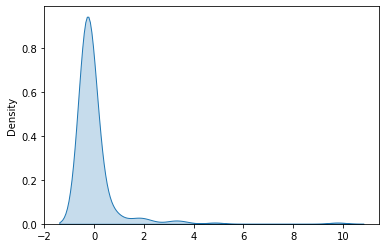

In [91]:
sns.kdeplot([(x-np.mean(genre_counts[0]))/np.std(genre_counts[0]) for x in genre_counts[0]],shade=True)
sns.kdeplot(np.random.normal(),shade=True)
#sns.kdeplot(genre_counts[2],shade=True)